# **TSA Group Project**
## DS207: Time Series Analysis

Alisa Martirosyan

Ara Abovyan

Anzhel Torosyan

Jeni Balaban

Mery Asatryan

### **Description**

#### **Problem:** *Web Traffic Time Series Forecasting*
- Identifying the nature of the phenomenon
- Forecasting future web traffic for Wikipedia articles

The analyzing and forecasting process is going to be conducted considering the articles grouped by the languages they're written in.
The languages are the following:
- de- German
- en- English
- es- Spanish
- fr- French
- ja- Japanese
- ru- Russian
- zh- Chinese

The forecasting is going to consist of the following steps:
- Data cleaning, preprocessing.
- Visualizations, initial inspection of the data.
- Removing anomalies, if necessary.
- Apply SARIMA, Halt-Winters, XGBoost models wherever applicable.
- Apply Exponential Smoothing Models, wherever applicable.
- During the entire process compare the outcomes of these models considering different languages.
- Choose the best model for each language-data considering visual inspections and error analysis.

P.S. This is the initial plan considering our syllabus and is subject to change to better fit our dataset's requirements considering possible future "discoveries" about the data.

Dataset retrieved from:
https://www.kaggle.com/c/web-traffic-time-series-forecasting


## **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.cm as cm
import xgboost as xgb
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The training dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July 1st, 2015 up until December 31st, 2016.

## **Importing Data and Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/Users/araabovyan/Projects/notebooks/data/train_1.csv')
data.head()

# Setting index, this is needed to get rid of n/a values
data = data.set_index('Page')

In [ ]:
# Display missing values.
null_data = data[data.isnull().any(axis=1)]
null_data.shape

(27786, 550)

In [ ]:
total = np.product(data.shape)
total_missing = data.isnull().sum().sum()
percentage_missing = (total_missing / total) * 100

print(f"The dataset contains {percentage_missing:.2f}% missing values")

The dataset contains 7.76% missing values


In [ ]:
# Removing rows thtat has more than 10% missing values
data.dropna(thresh=data.shape[1]*0.9, inplace=True)

# Replacing the missing values with the corresponding row mean
data = data.apply(lambda row: row.fillna(row.median()), axis=1)
data = data.astype(int)

In [ ]:
# Double checking missing values
total = np.product(data.shape)
total_missing = data.isnull().sum().sum()
percentage_missing = (total_missing / total) * 100

print(f"The dataset contains {percentage_missing:.2f}% missing values")

The dataset contains 0.00% missing values


In [ ]:
# Resetting index which was set for removing nan data
data.reset_index(inplace=True)

# Extracting information from the 'Page' column
api_info = data.Page.str.extract(r'(?P<Name>.*)\_(?P<Language>.*).wikipedia.org\_(?P<Access>.*)\_(?P<Type>.*)')

# Concatinating the extracted information with the original data
modified_data = pd.concat([api_info, data], axis=1)
modified_data.dropna(inplace=True)
modified_data.head()

,Name,Language,Access,Type,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access,spider,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,...,32,63,15,26,14,20,22,19,18,20
1,2PM,zh,all-access,spider,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,...,17,42,28,15,9,30,52,45,26,20
2,3C,zh,all-access,spider,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,...,3,1,1,7,4,4,6,3,4,17
3,4minute,zh,all-access,spider,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,...,32,10,26,27,16,11,17,19,10,11
4,5566,zh,all-access,spider,5566_zh.wikipedia.org_all-access_spider,12,7,4,5,20,...,16,27,8,17,32,19,23,17,17,50


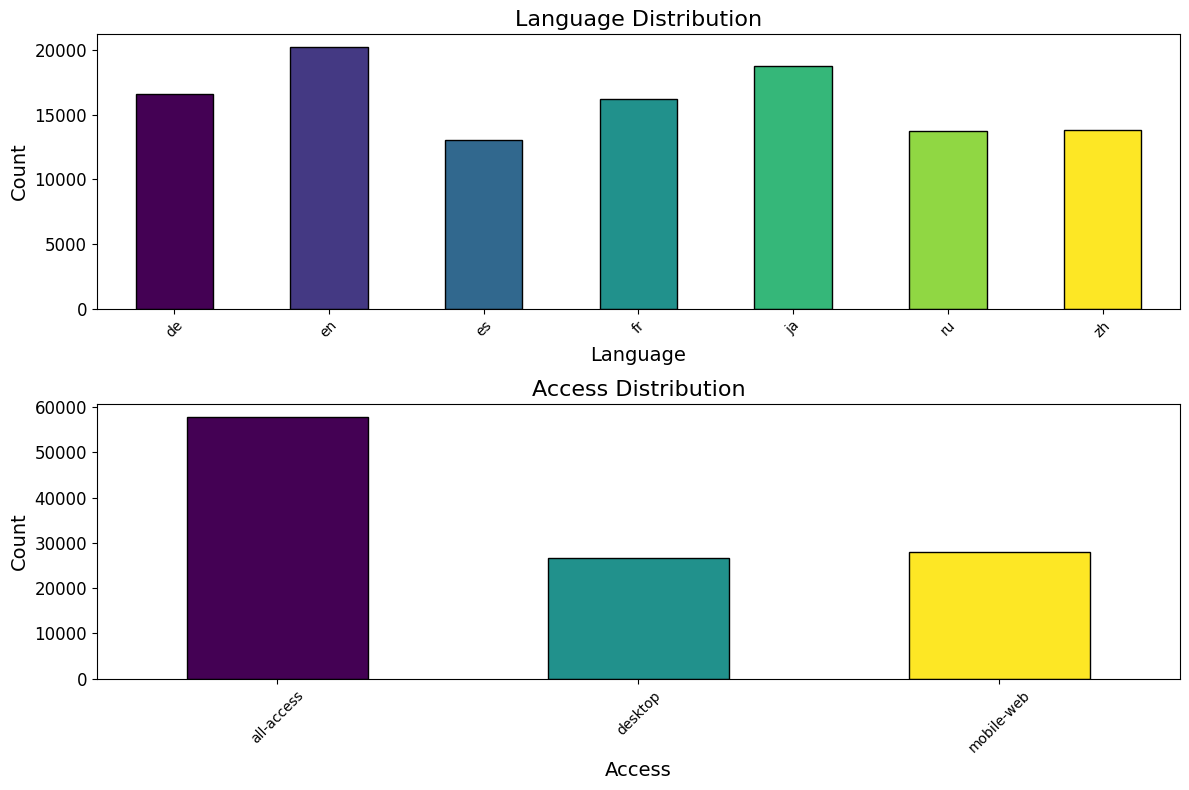

In [ ]:
plt.style.use('default')

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

columns_titles = {
    "Language": "Language Distribution",
    "Access": "Access Distribution"
}

for ax, (column, title) in zip(axs, columns_titles.items()):
    value_counts = api_info[column].value_counts().sort_index()
    n_categories = len(value_counts)

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, n_categories))

    value_counts.plot.bar(ax=ax, color=colors, edgecolor='black')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', labelsize=12)

    ax.grid(False)

plt.tight_layout()

plt.show()

In [ ]:
print(modified_data['Language'].unique())

['zh' 'fr' 'en' 'ru' 'de' 'ja' 'es']


In [ ]:
modified_data = modified_data[modified_data['Language'].isin(['ru', 'en', 'es'])]

In [ ]:
data_cleaned = modified_data.drop(columns=['Name', 'Access', 'Type', 'Page'])

data_pivoted = data_cleaned.melt(id_vars=['Language'], var_name='Date', value_name='Traffic')

data_pivoted['Date'] = pd.to_datetime(data_pivoted['Date'])

data_pivoted = data_pivoted.groupby(['Language', 'Date']).sum().reset_index()

In [ ]:
print(data_pivoted.info())
print(data_pivoted.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Language  1650 non-null   object        
 1   Date      1650 non-null   datetime64[ns]
 2   Traffic   1650 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 38.8+ KB
None
  Language       Date   Traffic
0       en 2015-07-01  84692953
1       en 2015-07-02  84440972
2       en 2015-07-03  80146187
3       en 2015-07-04  83602237
4       en 2015-07-05  86359904


In [ ]:
# Make seperate DataFrame for each language
language_dfs = {}
for language in data_pivoted['Language'].unique():
    language_data = data_pivoted[data_pivoted['Language'] == language]
    language_dfs[language] = language_data[['Date', 'Traffic']].copy()

In [ ]:
print(data_pivoted['Traffic'].describe())

count    1.650000e+03
mean     4.487633e+07
std      4.356387e+07
min      7.436622e+06
25%      1.364665e+07
50%      1.734654e+07
75%      9.017143e+07
max      1.964817e+08
Name: Traffic, dtype: float64


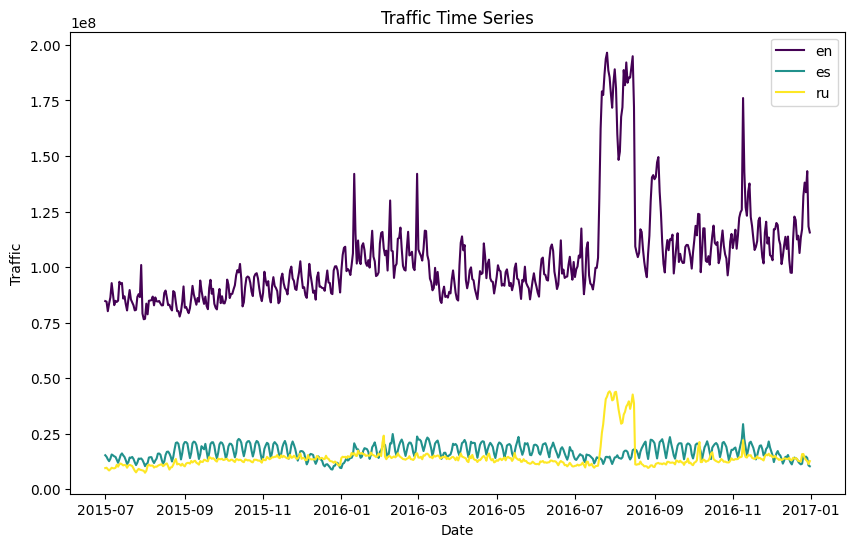

In [ ]:
#Plotting all languages together

num_languages = len(language_dfs)
colors = cm.viridis(np.linspace(0, 1, num_languages))

plt.figure(figsize=(10, 6))
for (language, language_df), color in zip(language_dfs.items(), colors):
    plt.plot(language_df['Date'], language_df['Traffic'], label=language, color=color)

plt.title("Traffic Time Series")
plt.xlabel("Date")
plt.ylabel("Traffic")
plt.legend()
plt.show()

Plotting together the data about all the languages doesn't give much information as the English articles have tremendously more web traffic than the articles in other languages.

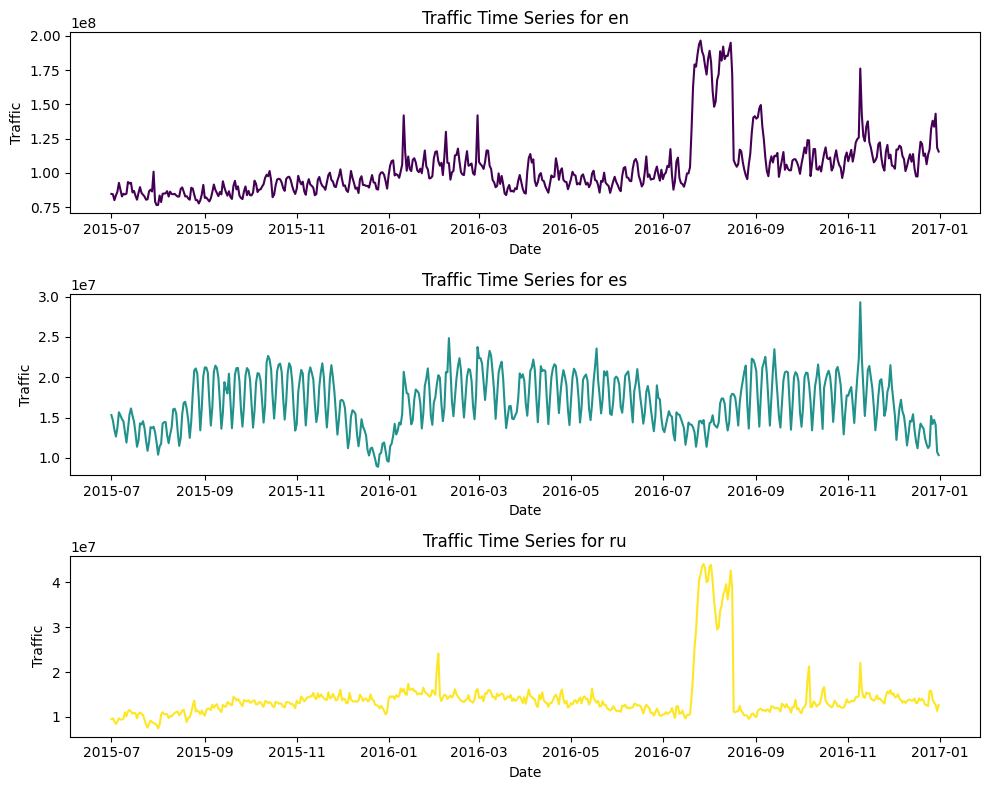

In [ ]:
num_languages = len(language_dfs)
num_rows = num_languages
num_cols = 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8), squeeze=False)
axes = axes.flatten()

colors = cm.viridis(np.linspace(0, 1, num_languages))

# Plotting for each language
for i, ((language, language_df), color) in enumerate(zip(language_dfs.items(), colors)):
    ax = axes[i]
    ax.plot(language_df['Date'], language_df['Traffic'], color=color)
    ax.set_title(f"Traffic Time Series for {language}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Traffic")

for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These plots show that the data is most likely seasonal and slightly trendy. We can also state that the data doesn't seem stationary. If we're looking closely we can see spikes in trafiic data in all the languages.

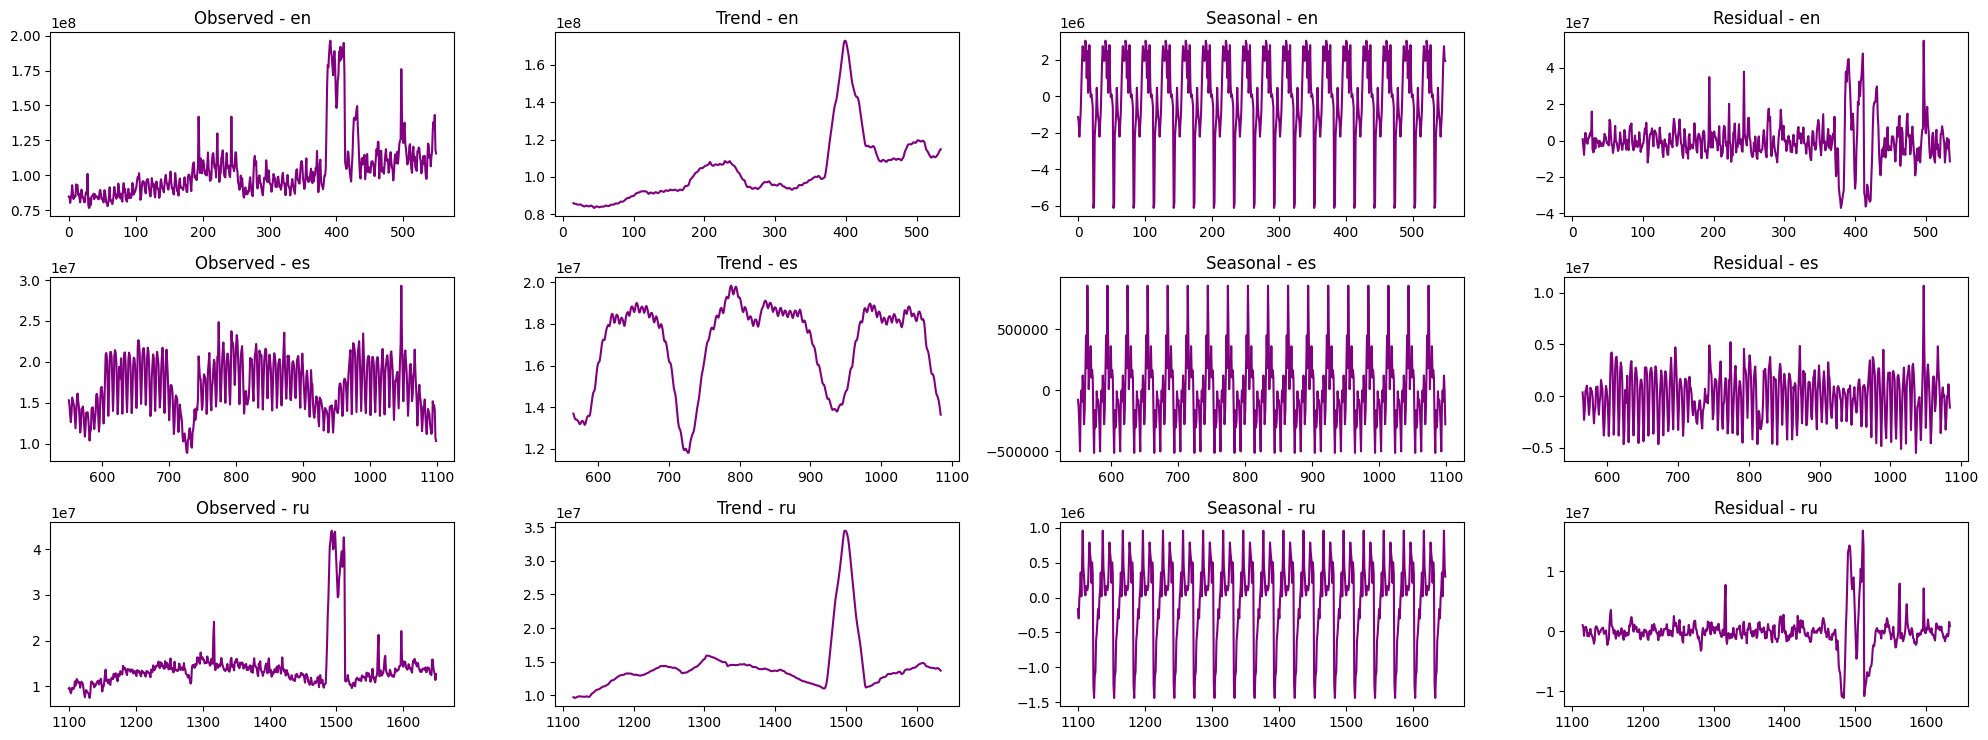

In [ ]:
#Seasonal decomposition to observe the seasonality of the data

from statsmodels.tsa.seasonal import seasonal_decompose

num_plots = len(language_dfs)
fig, axs = plt.subplots(num_plots, 4, figsize=(20, num_plots*2.5))  # Adjusted layout for clarity

color = 'purple'
for i, (language, language_df) in enumerate(language_dfs.items()):
    # Decompose the time series data
    result = seasonal_decompose(language_df['Traffic'], model='additive', period=30)

    # Plot each component with increased line thickness
    result.observed.plot(ax=axs[i, 0], title=f'Observed - {language}', color=color)
    result.trend.plot(ax=axs[i, 1], title=f'Trend - {language}', color=color)
    result.seasonal.plot(ax=axs[i, 2], title=f'Seasonal - {language}', color=color)
    result.resid.plot(ax=axs[i, 3], title=f'Residual - {language}', color=color)

plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm

for i, (language, language_df) in enumerate(language_dfs.items()):

    # Perform STL decomposition
    result = sm.tsa.seasonal_decompose(language_df['Traffic'], period=7)

    trend_var = np.nanvar(result.trend)
    seasonal_var = np.nanvar(result.seasonal)
    residual_var = np.nanvar(result.resid)

    # Total variance
    total_var = trend_var + seasonal_var + residual_var

    # Calculate the strength of trend and seasonality
    trend_strength = trend_var / total_var
    seasonality_strength = seasonal_var / total_var

    print(language)
    print(f'Seasonality Strength: {seasonality_strength:>14.4f}')
    print(f'Trend Strength: {trend_strength:>20.4f}')
    print()

en
Seasonality Strength:         0.0370
Trend Strength:               0.9003

es
Seasonality Strength:         0.3621
Trend Strength:               0.5521

ru
Seasonality Strength:         0.0056
Trend Strength:               0.9338



It's evident, that the data for all the languages is seasonal and slightly trendy.

In [ ]:
# Conducting ADF
p_values = {}
for language, language_df in language_dfs.items():
    p_value = adfuller(language_df["Traffic"])[1]
    reject_null = "✓" if p_value < 0.05 else "X"
    p_values[language] = (p_value, reject_null)

sorted_p_values = sorted(p_values.items(), key=lambda item: item[1][0])

print(f'{"Language":^10} | {"p-value":^12} | {"Reject H0":^10}')
print('-' * 37)

for language, (p_value, reject_null) in sorted_p_values:
    print(f'{language:^10} | {p_value:^12.1e} | {reject_null:^10}')

 Language  |   p-value    | Reject H0 
-------------------------------------
    ru     |   1.7e-03    |     ✓     
    es     |   4.0e-02    |     ✓     
    en     |   1.2e-01    |     X     


In the case of the Russian and Spanish Web Traffic data we can reject the null hypothesis as the p-value is less than 0.05, hence the data is stationary. For the other we fail to reject the null hypothesis as the p-value is greater than 0.05, hence the data is non-stationary. However, please note that all the language data are non-stationary since they are seasonal, and the ADF test ignores the seasonality.

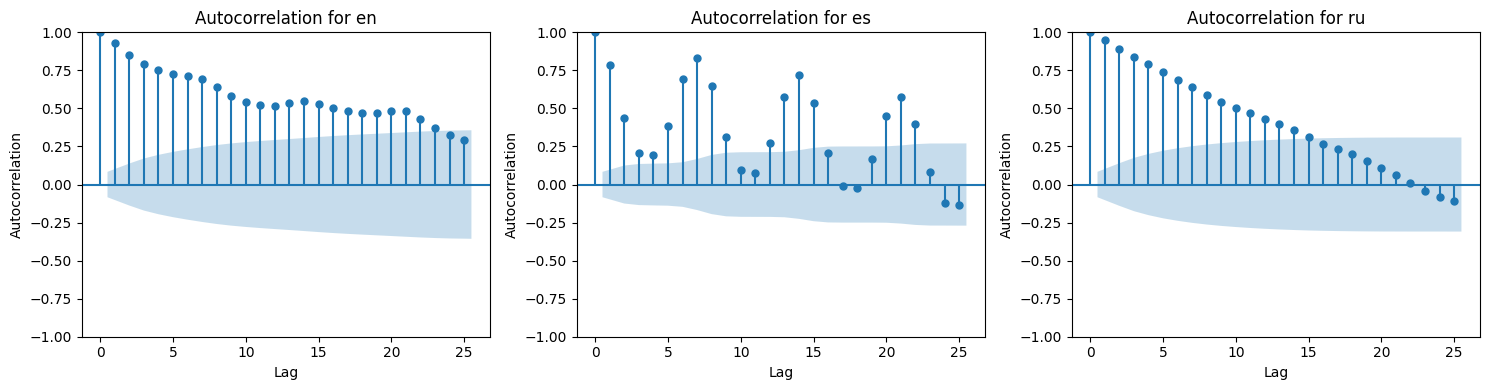

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, len(language_dfs), figsize=(15, 4))
axes = axes.flatten()

for i, (language, language_df) in enumerate(language_dfs.items()):
    ax = axes[i]
    plot_acf(language_df['Traffic'], ax=ax, title=f"Autocorrelation for {language}", lags=25)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()

We can see the trendy behaviour in all the languages. Besides the trendy behaviour we can also see a strong seasonality in the Spanish plot.

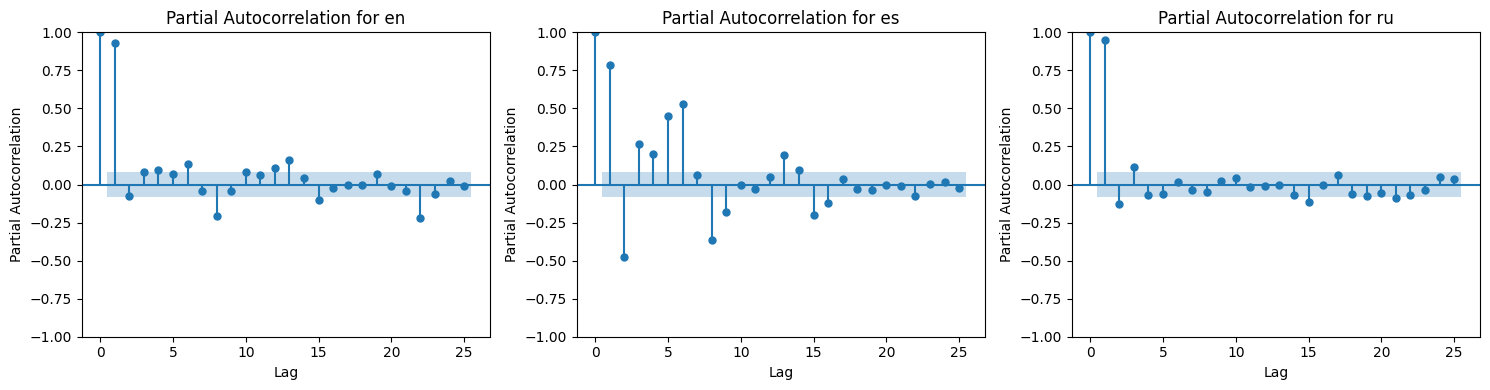

In [ ]:
fig, axes = plt.subplots(1, len(language_dfs), figsize=(15, 4))

for i, (language, language_df) in enumerate(language_dfs.items()):
    ax = axes[i]
    plot_pacf(language_df['Traffic'], ax=ax, title=f"Partial Autocorrelation for {language}", lags=25)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Partial Autocorrelation")

plt.tight_layout()
plt.show()

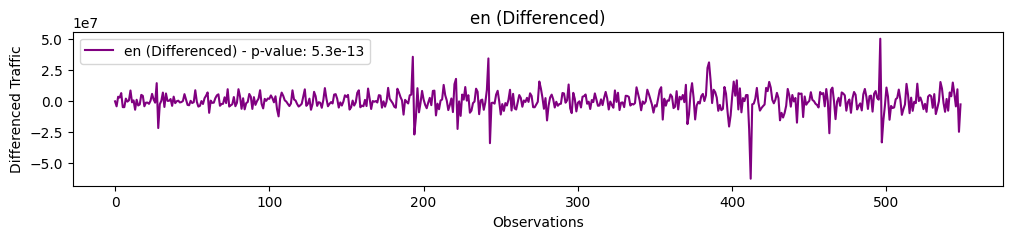

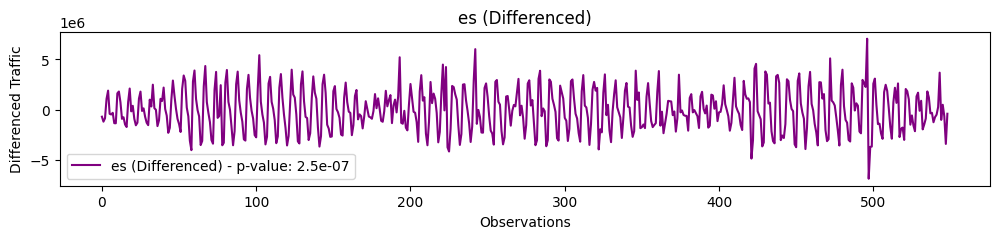

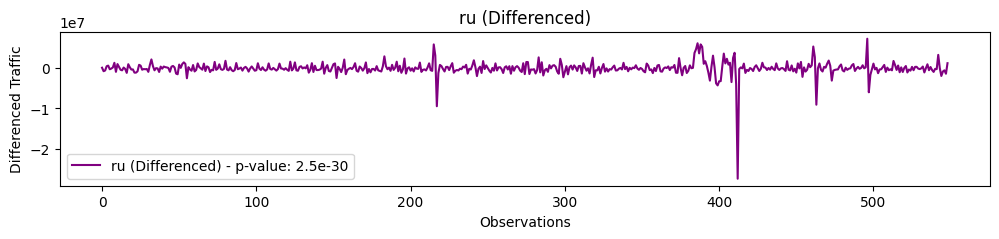

In [ ]:
# Dictionary to hold new differenced DataFrames
differenced_dfs = {}

for language, language_df in language_dfs.items():
    # Perform differencing
    data_diff = np.diff(language_df['Traffic'])
    differenced_df = pd.DataFrame(data_diff, columns=['Traffic'])
    differenced_dfs[language] = differenced_df

    # Perform ADF test on the differenced data
    result_diff = adfuller(data_diff)
    p_value_diff = result_diff[1]

    # Plotting
    plt.figure(figsize=(12, 2))
    plt.plot(data_diff, label=language + " (Differenced) - p-value: {:.1e}".format(p_value_diff), color ="purple")
    plt.title(f"{language} (Differenced)")
    plt.xlabel('Observations')
    plt.ylabel('Differenced Traffic')
    plt.legend()
    plt.show()


Here we're differencing with lag 1 to address the trendy behaviour. We can see from the plots that it's not enough to make our data acceptable in order to perform different models on it. So we need to difference again to address the seasonality component.

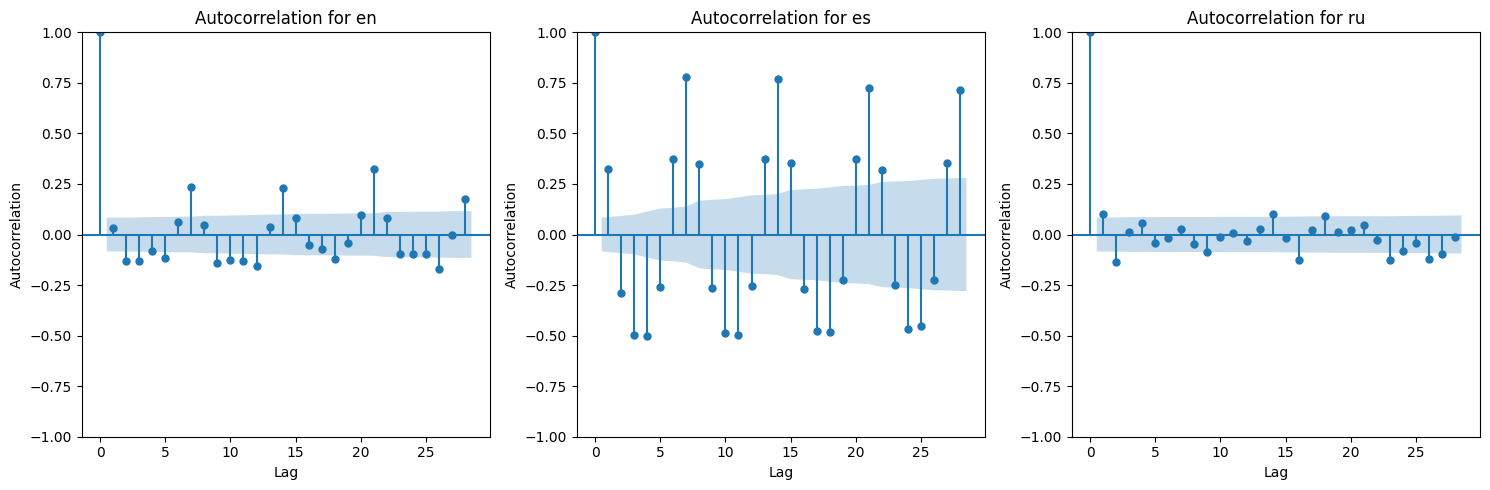

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

num_languages = len(language_dfs)
num_cols = 3
num_rows = (num_languages + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i, (language, language_df) in enumerate(differenced_dfs.items()):
    ax = axes[i]
    plot_acf(language_df['Traffic'], ax=ax, title=f"Autocorrelation for {language}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")

for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

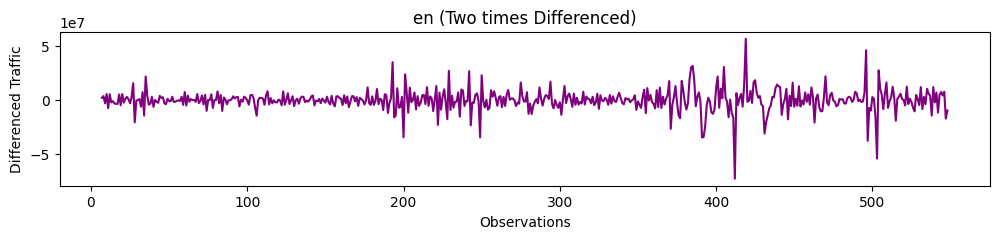

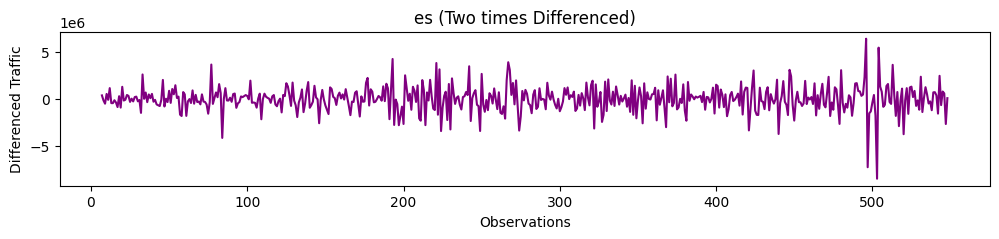

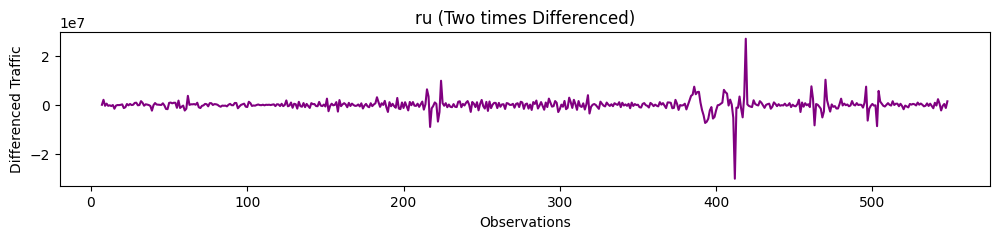

In [ ]:
# Dictionary to hold new differenced DataFrames
differenced_diff_dfs = {}

for language, language_df in differenced_dfs.items():
    # Perform differencing
    data_diff = language_df['Traffic'].diff(7)
    differenced_df = pd.DataFrame(data_diff, columns=['Traffic'])
    differenced_diff_dfs[language] = differenced_df.dropna()

    # Plotting
    plt.figure(figsize=(12, 2))
    plt.plot(data_diff, color = "purple")
    plt.title(f"{language} (Two times Differenced)")
    plt.xlabel('Observations')
    plt.ylabel('Differenced Traffic')
    plt.show()


Here we're differencing with lag 7 to address the seasonality component as our data has weekly seasonality. We can see from the plots that it's already more stable with 0 mean and stable variance with just a few outliers. So we can now proceed with splitting the data into training and testing sets and performing the necessary models on them.

In [ ]:
# Check the shape of each DataFrame in differenced_dfs
for language, df in differenced_diff_dfs.items():
    print(f"Language: {language}, Shape: {df.shape}")

Language: en, Shape: (542, 1)
Language: es, Shape: (542, 1)
Language: ru, Shape: (542, 1)


In [ ]:
# Dictionary to hold train and test sets
train_set = {}
test_set = {}
test_size = 0.07

for language, df in language_dfs.items():
    ts = df['Traffic'].reset_index(drop=True)
    split_index = int(len(ts) * test_size)
    train = ts[:-split_index]
    test = ts[-split_index:]
    train_set[language] = train
    test_set[language] = test

We've decided to split the data in the following way: for each language 93% of the data is going to be for training and the other 7% of the data is going to be for testing.

In [ ]:
datasets = {
    'English': train_set['en'],
    'Spanish': train_set['es'],
    'Russian': train_set['ru'],
}

test_datasets = {
    'English': test_set['en'],
    'Spanish': test_set['es'],
    'Russian': test_set['ru'],
}

performance_metrics = {
    'Language': [],
    'Method': [],
    'SSE': [],
    'MSE': []
}

# Seasonal Naive

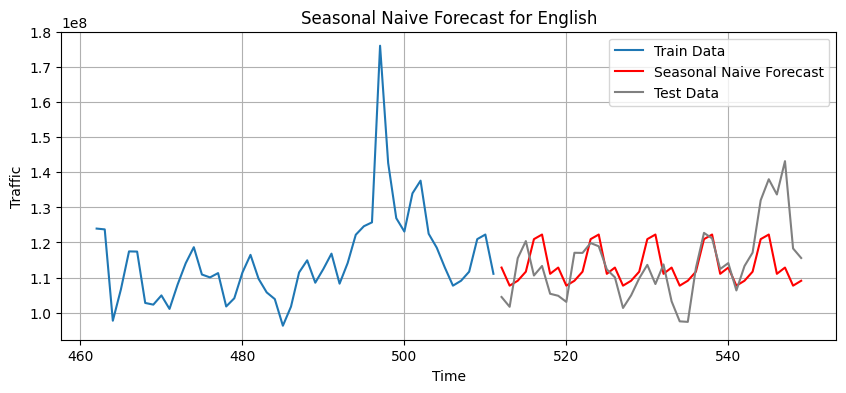

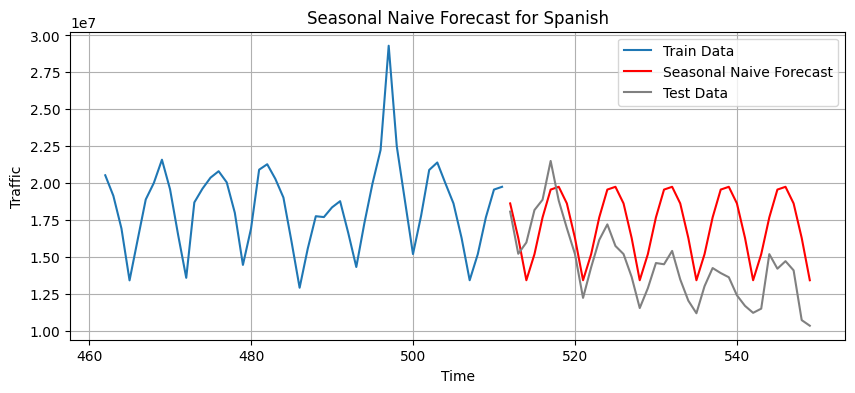

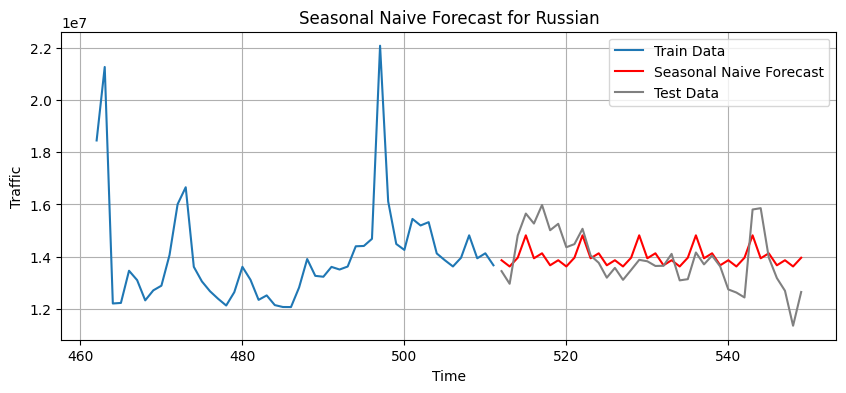

In [ ]:
def seasonal_naive_forecast(train_data, test_data, seasonal_period):
    last_seasonal_observations = train_data.iloc[-seasonal_period:]
    forecast = [last_seasonal_observations.iloc[i % seasonal_period] for i in range(len(test_data))]
    return forecast, None

seasonal_naive_mse = {}
seasonal_naive_sse = {}

performance_df = pd.DataFrame(columns=['Language', 'Method', 'MSE', 'SSE'])

for language, train_data in datasets.items():
    seasonal_period = 7
    test_data = test_datasets[language]
    forecast, _ = seasonal_naive_forecast(train_data, test_data, seasonal_period)

    # Calculate MSE and SSE
    mse = mean_squared_error(test_data, forecast)
    sse = np.sum((forecast - test_data) ** 2)

    new_data = pd.DataFrame({
        'Language': [language],
        'Method': ['Seasonal Naive'],
        'MSE': [mse],
        'SSE': [sse]
    })

    performance_df = pd.concat([performance_df, new_data], ignore_index=True)

    plt.figure(figsize=(10, 4))
    plt.plot(train_data[-50:], label='Train Data')
    plt.plot(test_data.index, forecast, color='red', label='Seasonal Naive Forecast')
    plt.plot(test_data, color='gray', label='Test Data')
    plt.title(f"Seasonal Naive Forecast for {language}")
    plt.xlabel("Time")
    plt.ylabel("Traffic")
    plt.legend()
    plt.grid(True)
    plt.show()


After performing the Seasonal Naive model we can see that it's working in a moderate way, but as it's just copy-pasting the last seasonal period it doesn't address the spikes well.

# SARIMA - Meri

In [ ]:
d = 1  # Non-seasonal differencing
D = 1  # Seasonal differencing
s = 7  # Seasonal period (e.g., monthly data)

# Ranges for p, q, P, and Q
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

order_list = list(product(ps, qs, Ps, Qs))

results_summary = []

for language, train in datasets.items():
    best_aic = np.inf
    best_order = None

    for order in order_list:
        model = SARIMAX(train, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s))
        result = model.fit(disp=False)
        aic = result.aic

        if aic < best_aic:
            best_aic = aic
            best_order = order

    results_summary.append((language, best_order, best_aic))

for result in results_summary:
    print(f'Language: {result[0]}, Best Params (p, q, P, Q): {result[1]}, Best AIC: {result[2]}')


Language: English, Best Params (p, q, P, Q): (0, 0, 2, 2), Best AIC: 17393.46724919541
Language: Spanish, Best Params (p, q, P, Q): (0, 0, 1, 2), Best AIC: 15504.60350398159
Language: Russian, Best Params (p, q, P, Q): (0, 0, 1, 2), Best AIC: 16003.563969653875


Considering the best AIC we've chosen the following parameters for our SARIMA models:

- English: SARIMA(0, 1, 0)(2, 1, 2)7

- Spanish: SARIMA(0, 1, 0)(1, 1, 2)7

- Russian: SARIMA(0, 1, 0)(1, 1, 2)7

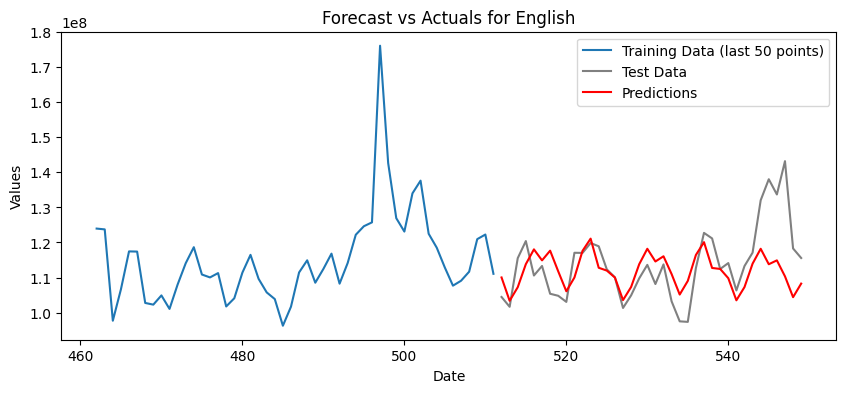

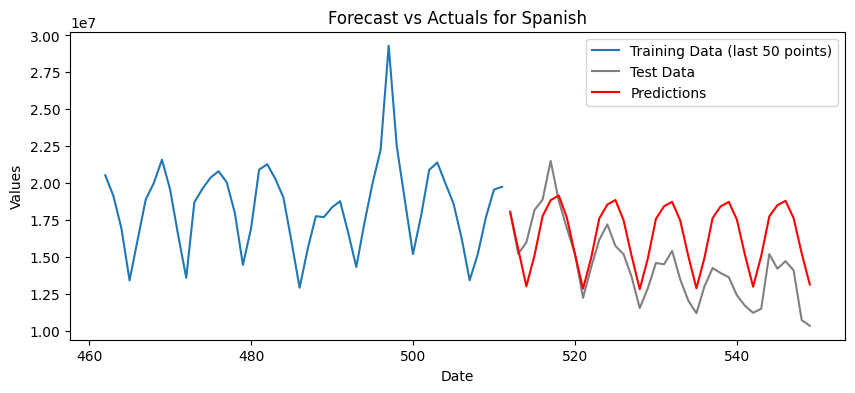

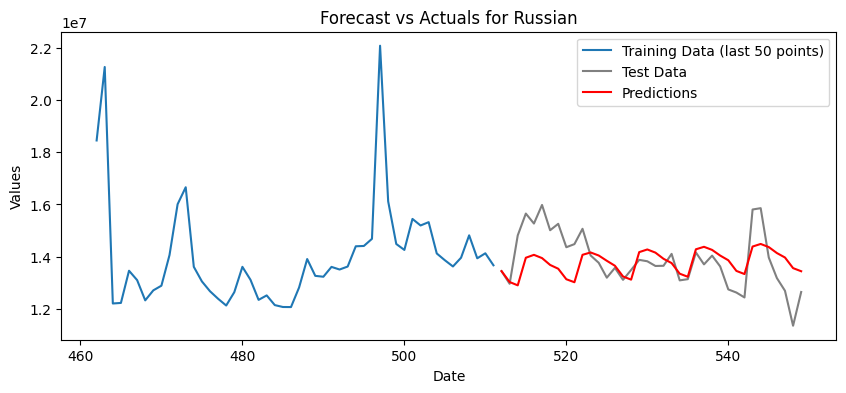

In [ ]:
for language, params, _ in results_summary:
    train = datasets[language]
    test = test_datasets[language]
    sarima_model = SARIMAX(train,
                    order=(params[0], d, params[1]),
                    seasonal_order=(params[2], D, params[3], s))
    result = sarima_model.fit(disp=False)

    predictions = result.get_forecast(steps=len(test))
    predicted_means = predictions.predicted_mean

    # Calculate SSE and MSE
    sse = ((predicted_means - test) ** 2).sum()
    mse = mean_squared_error(test, predicted_means)

    new_data = pd.DataFrame({
        'Language': [language],
        'Method': ['SARIMA'],
        'MSE': [mse],
        'SSE': [sse]
    })
    performance_df = pd.concat([performance_df, new_data], ignore_index=True)

    plt.figure(figsize=(10, 4))
    plt.plot(train[-50:].index, train[-50:], label='Training Data (last 50 points)')
    plt.plot(test.index, test, label='Test Data', color='gray')
    plt.plot(test.index, predicted_means, label='Predictions', color='red')
    plt.title(f'Forecast vs Actuals for {language}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

Our SARIMA models are also working in a moderate way as they're unable to address the spikes (English) and the decreasing trendy behaviours (Spanish, Russian) of our data.

# Holt-Winter forecasting

In [ ]:
# Adjust the parameter range to avoid extreme values
alpha_values = np.linspace(0.1, 0.9, 9)
beta_values = np.linspace(0.1, 0.9, 9)
gamma_values = np.linspace(0.1, 0.9, 9)

def grid_search_hw(train_data, test_data, alpha_values, beta_values, gamma_values):
    best_score = float("inf")
    best_params = None

    for alpha in alpha_values:
        for beta in beta_values:
            for gamma in gamma_values:
                try:
                    train_data_filled = train_data.fillna(method='ffill').fillna(method='bfill') + 1

                    model = ExponentialSmoothing(
                        train_data_filled,
                        trend='add',
                        damped_trend=True,
                        seasonal='add',
                        seasonal_periods=7
                    ).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma, optimized=True)

                    forecast_values = model.forecast(len(test_data))

                    mse = mean_squared_error(test_data, forecast_values)

                    if mse < best_score:
                        best_score = mse
                        best_params = (alpha, beta, gamma)
                except Exception as e:
                    print(f"Failed to fit model with alpha={alpha}, beta={beta}, gamma={gamma}: {e}")

    return best_score, best_params

# Run the grid search
best_score, best_params = grid_search_hw(datasets['English'], test_datasets['English'], alpha_values, beta_values, gamma_values)
print("Best MSE:", best_score)
print("Best parameters: alpha =", best_params[0], ", beta =", best_params[1], ", gamma =", best_params[2])

Best MSE: 65687644807260.1
Best parameters: alpha = 0.2 , beta = 0.6 , gamma = 0.2


In [ ]:
hw_best_models = {}
mse_scores = {}

for language, data in datasets.items():
    train = data
    test = test_datasets[language]

    configurations = [('add', 'add'), ('add', 'mul'), ('mul', 'add'), ('mul', 'mul')]
    best_mse = np.inf
    best_model = None

    for trend, seasonal in configurations:
        hw_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=7, damped_trend=True,).fit()
        predictions = hw_model.forecast(len(test))
        mse = mean_squared_error(test, predictions)
        sse = np.sum((predictions - test) ** 2)

        if mse < best_mse:
            best_mse = mse
            hw_best_model = (hw_model, trend, seasonal)

    hw_best_models[language] = hw_best_model
    mse_scores[language] = best_mse

    new_data = pd.DataFrame({
        'Language': [language],
        'Method': ['Holt-Winters'],
        'MSE': [best_mse],
        'SSE': [sse]
    })
    performance_df = pd.concat([performance_df, new_data], ignore_index=True)

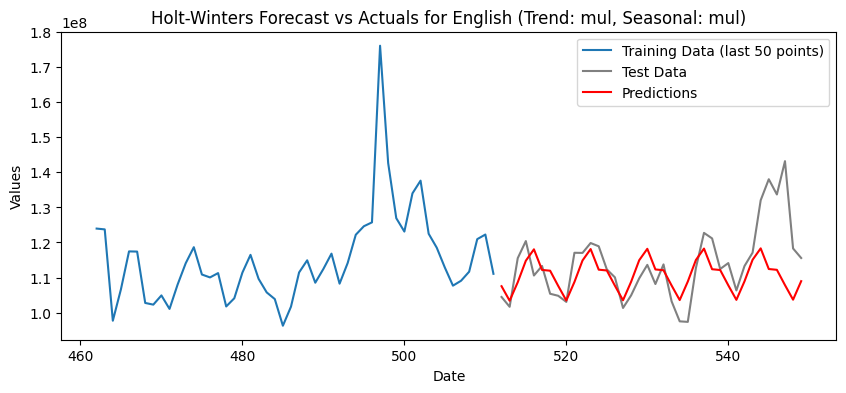

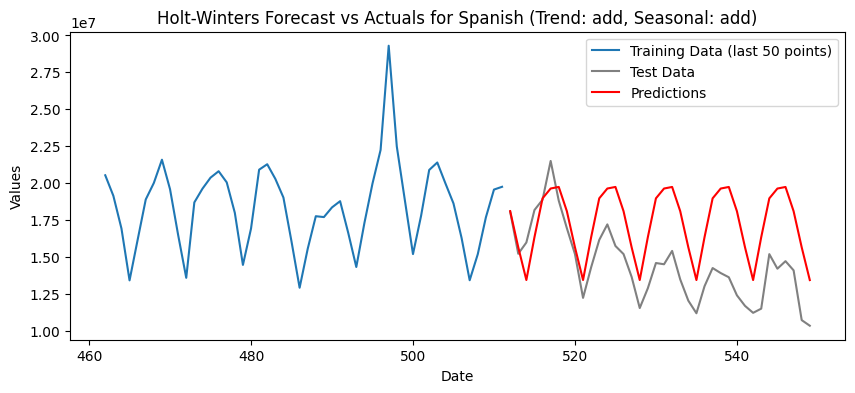

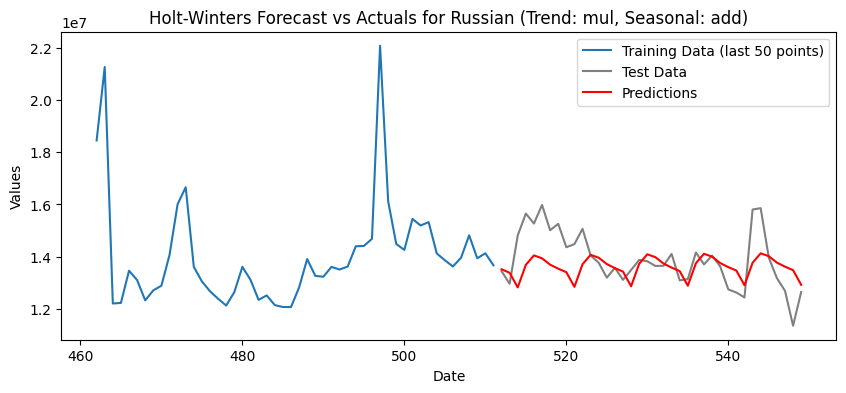

In [ ]:
for language, (model, trend, seasonal) in hw_best_models.items():
    predictions = model.forecast(len(test_datasets[language]))

    train = datasets[language]
    plt.figure(figsize=(10, 4))
    plt.plot(train.index[-50:], train[-50:], label='Training Data (last 50 points)')
    plt.plot(test_datasets[language].index, test_datasets[language], label='Test Data', color='gray')
    plt.plot(test_datasets[language].index, predictions, label='Predictions', color='red')
    plt.title(f'Holt-Winters Forecast vs Actuals for {language} (Trend: {trend}, Seasonal: {seasonal})')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


The approaches for Holt-Winters models are different and are chosen considering the best performance.

- English: Multiplicative Trend and Multiplicative Seasonal

- Spanish: Additive Trend and Additive Seasonal

- Russian: Multiplicative Trend and Additive Seasonal

Our Holt-Winters models are also working in a moderate way as they're unable to address the spikes (English) and the decreasing trendy behaviours (Spanish, Russian) of our data.

# XGBoost

In [ ]:
features = 7

def create_features(data, features):
    X, y = [], []
    for i in range(features, len(data)):
        X.append(data[i-features:i])
        y.append(data[i])
    return np.array(X), np.array(y)

xgb_datasets = {}
for language, data in datasets.items():
    X, y = create_features(data.values, features)
    xgb_datasets[language] = (X, y)


In [ ]:
xgb_models = {}
for language, (X, y) in xgb_datasets.items():
    model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=1000)
    model.fit(X, y)
    xgb_models[language] = model

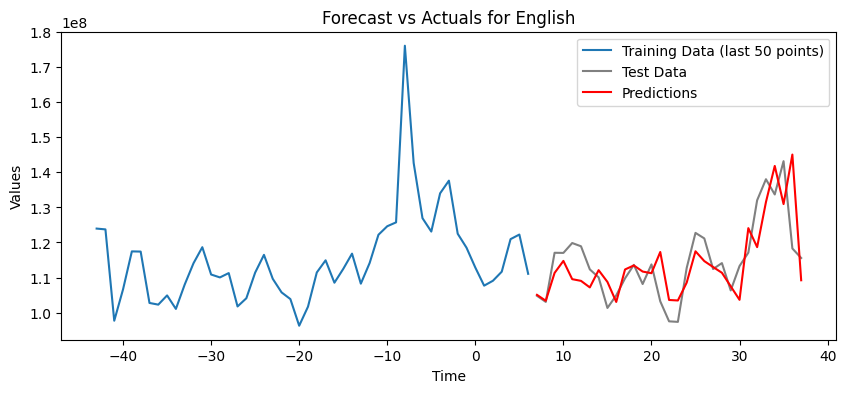

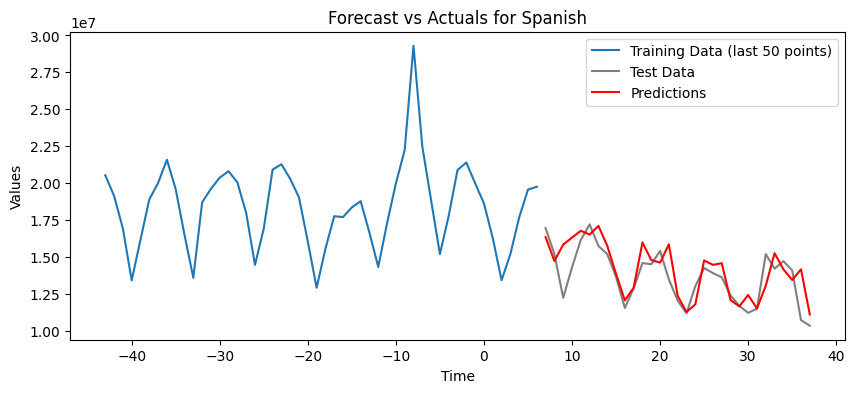

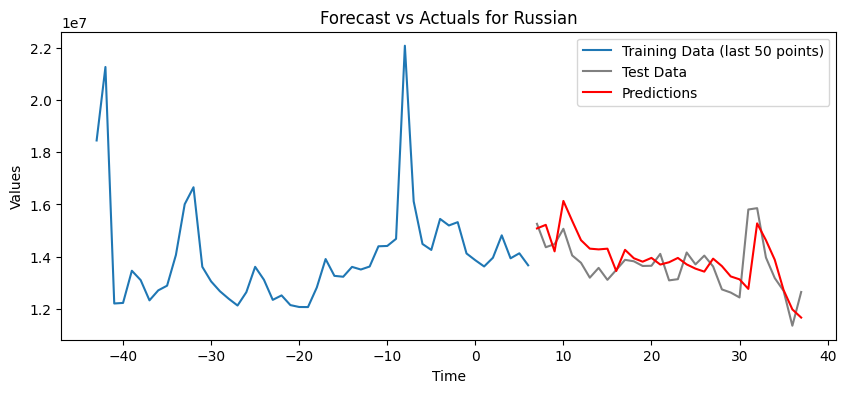

In [ ]:
for language in datasets.keys():
    test_X, test_y = create_features(test_datasets[language].values, features)
    predictions = xgb_models[language].predict(test_X)

    sse = np.sum((predictions - test_y) ** 2)
    mse = mean_squared_error(test_y, predictions)

    new_data = pd.DataFrame({
        'Language': [language],
        'Method': ['XGBoost'],
        'SSE': [sse],
        'MSE': [mse]
    })
    performance_df = pd.concat([performance_df, new_data], ignore_index=True)

    plt.figure(figsize=(10, 4))

    train_indices = range(len(test_datasets[language]) - len(test_y) - 50, len(test_datasets[language]) - len(test_y))
    plt.plot(train_indices, datasets[language][-50:], label='Training Data (last 50 points)')

    test_indices = range(len(test_datasets[language]) - len(test_y), len(test_datasets[language]))
    plt.plot(test_indices, test_y, label='Test Data', color='gray')

    plt.plot(test_indices, predictions, label='Predictions', color='red')
    plt.title(f'Forecast vs Actuals for {language}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


We can see that the XGBoost works well with our data as compared to the others it's able to address the spikes and the decreasing trend.

# Results

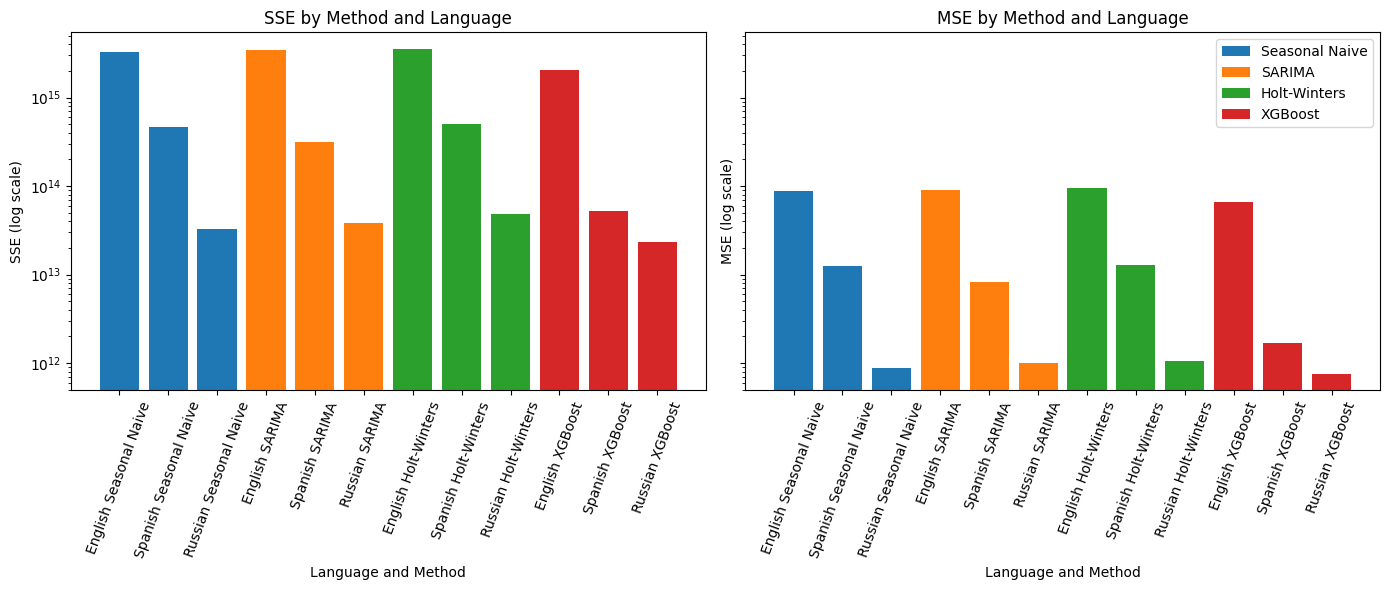

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# SSE plot with logarithmic scale
for method in performance_df['Method'].unique():
    subset = performance_df[performance_df['Method'] == method]
    axes[0].bar(subset['Language'] + ' ' + subset['Method'], subset['SSE'], label=method)
axes[0].set_yscale('log')
axes[0].set_title('SSE by Method and Language')
axes[0].set_xlabel('Language and Method')
axes[0].set_ylabel('SSE (log scale)')
axes[0].tick_params(axis='x', rotation=70)

# MSE plot with logarithmic scale
for method in performance_df['Method'].unique():
    subset = performance_df[performance_df['Method'] == method]
    axes[1].bar(subset['Language'] + ' ' + subset['Method'], subset['MSE'], label=method)
axes[1].set_yscale('log')
axes[1].set_title('MSE by Method and Language')
axes[1].set_xlabel('Language and Method')
axes[1].set_ylabel('MSE (log scale)')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=70)

plt.tight_layout()
plt.show()


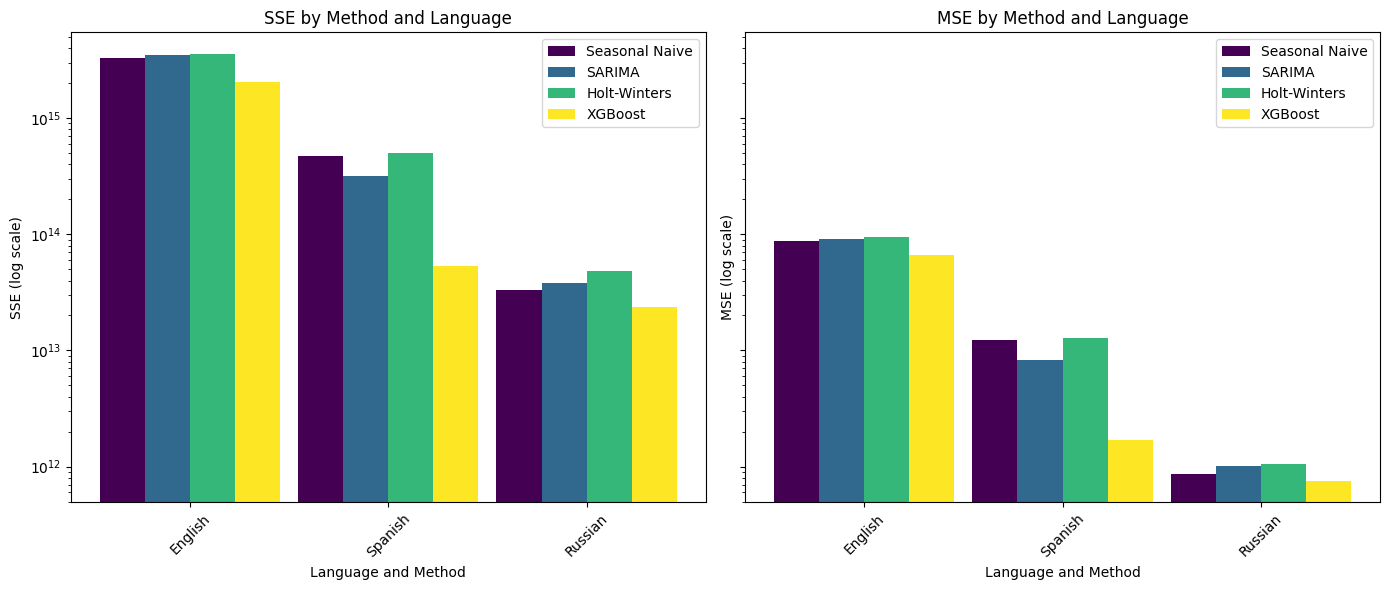

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

methods = performance_df['Method'].unique()
languages = performance_df['Language'].unique()
width = 0.25
spacing = 0.1

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(methods)))

num_methods = len(methods)
total_width = num_methods * width
group_width = total_width + spacing

positions = {lang: i * group_width for i, lang in enumerate(languages)}
offset = [-(total_width - width) / 2 + i * width for i in range(num_methods)]

# SSE plot with logarithmic scale
for method_idx, method in enumerate(methods):
    subset = performance_df[performance_df['Method'] == method]
    method_positions = [positions[lang] + offset[method_idx] for lang in subset['Language']]
    axes[0].bar(method_positions, subset['SSE'], width=width, color=colors[method_idx], label=method)

axes[0].set_yscale('log')
axes[0].set_title('SSE by Method and Language')
axes[0].set_xlabel('Language and Method')
axes[0].set_ylabel('SSE (log scale)')
axes[0].legend()
axes[0].set_xticks(list(positions.values()))
axes[0].set_xticklabels(languages)
axes[0].tick_params(axis='x', rotation=45)

# MSE plot with logarithmic scale
for method_idx, method in enumerate(methods):
    subset = performance_df[performance_df['Method'] == method]
    method_positions = [positions[lang] + offset[method_idx] for lang in subset['Language']]
    axes[1].bar(method_positions, subset['MSE'], width=width, color=colors[method_idx], label=method)

axes[1].set_yscale('log')
axes[1].set_title('MSE by Method and Language')
axes[1].set_xlabel('Language and Method')
axes[1].set_ylabel('MSE (log scale)')
axes[1].legend()
axes[1].set_xticks(list(positions.values()))
axes[1].set_xticklabels(languages)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Considering the results of the performances we can clearly see that XGBoost is winning and has the least error. The others have similar performances.

In [ ]:
def forecast_future(model, data, days, features):
    future_preds = data[-features:].tolist()
    for _ in range(days):
        pred_features = np.array([future_preds[-features:]])
        pred = model.predict(pred_features)
        future_preds.append(pred[0])
    return future_preds[-days:]


In [ ]:
whole_data = {
    'English': pd.concat([datasets['English'], test_datasets['English']]).reset_index(drop=True),
    'Spanish': pd.concat([datasets['Spanish'], test_datasets['Spanish']]).reset_index(drop=True),
    'Russian': pd.concat([datasets['Russian'], test_datasets['Russian']]).reset_index(drop=True),
}

forecasts = {}
for language, model in xgb_models.items():
    forecasts[language] = forecast_future(model, whole_data[language], 20, features)

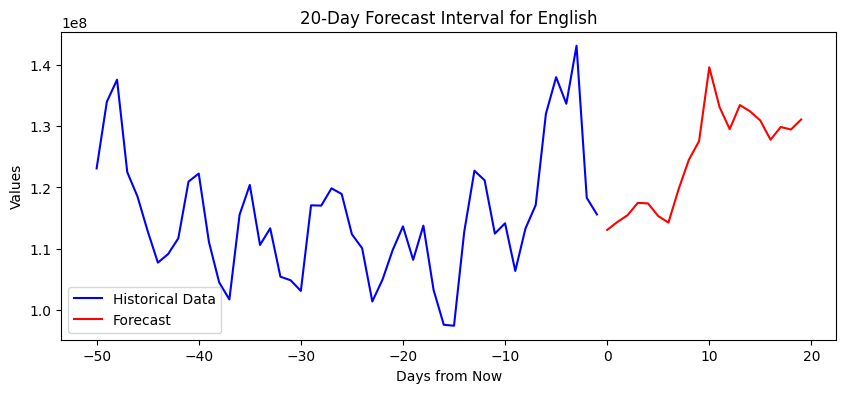

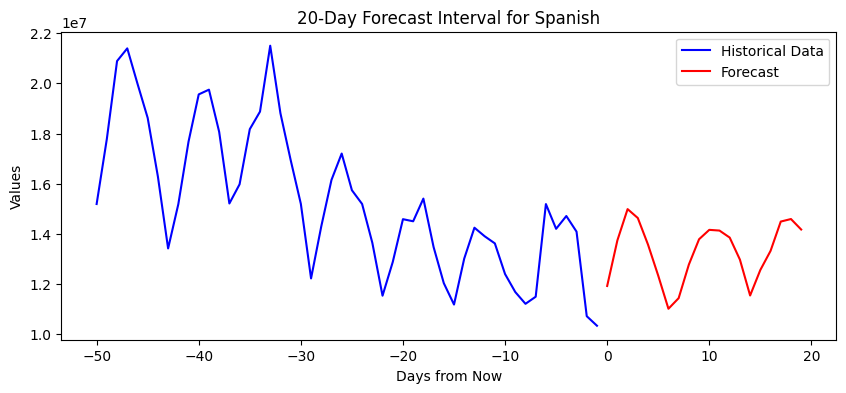

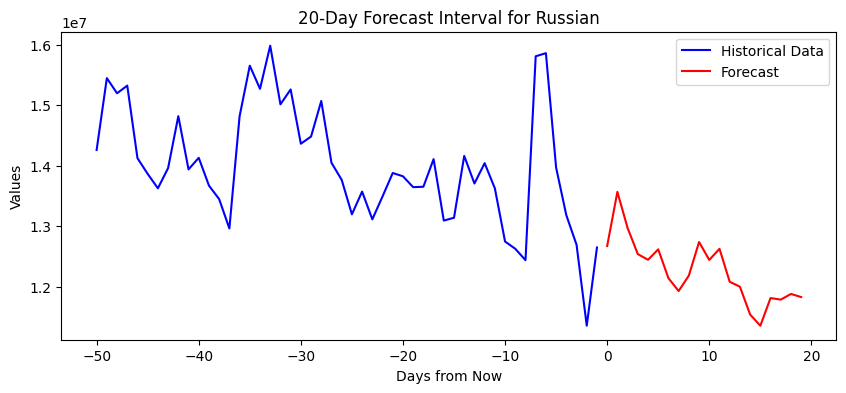

In [ ]:
for language, model in xgb_models.items():
    forecast = forecasts[language]

    plt.figure(figsize=(10, 4))

    historical_data = whole_data[language][-50:]
    plt.plot(range(-50, 0), historical_data, label='Historical Data', color='blue')

    plt.plot(range(0, 20), forecast, label='Forecast', color='red')

    plt.title(f'20-Day Forecast Interval for {language}')
    plt.xlabel('Days from Now')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


As XGBoost has the best performance we've done forecasting for the future 20 days after the historical data.